<a href="https://colab.research.google.com/github/ZahraFayyaz/3dshape-vqvae-pyTorch/blob/main/3dshapes_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Sentencepiece
!pip install transformers #==4.18.0

In [ ]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece
from transformers import TFDistilBertForMaskedLM, DistilBertConfig, AdamWeightDecay
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_y=np.load('/content/drive/MyDrive/Data/train_quantized.npy')
test_y=np.load('/content/drive/MyDrive/Data/test_quantized.npy')
embs=np.load('/content/drive/MyDrive/Data/embs.npy')


dtype('int64')

In [ ]:
n_train_samples, n_test_samples = train_y.shape[0], test_y.shape[0]
d_embed_vec = embs.shape[1]
n_tokens = np.prod(train_y.shape[1:3])
train_y = train_y.reshape((n_train_samples, n_tokens)).astype(int)
test_y = test_y.reshape((n_test_samples, n_tokens)).astype(int)

In [ ]:
# prompt: replace the elements of train_y with the sorresponding vector from embs
test_x = np.zeros((n_test_samples, n_tokens, d_embed_vec))
for i in range(n_test_samples):
  for j in range(n_tokens):
    test_x[i][j] = embs[test_y[i][j]]


In [ ]:
# prompt: rewrite the code in last cell for train_x

train_x = np.zeros((n_train_samples, n_tokens, d_embed_vec))
for i in tqdm(range(n_train_samples)):
  for j in range(n_tokens):
    train_x[i][j] = embs[train_y[i][j]]


100%|██████████| 384000/384000 [02:06<00:00, 3046.48it/s]


In [ ]:

vocab_size = embs.shape[0]

In [ ]:
mask_perc = 0.4
mask_token = 0  # does 0 make sense?

mask_train = np.random.default_rng().choice([True, False], size=(n_train_samples, n_tokens), p=[mask_perc, 1 - mask_perc])
mask_test = np.random.default_rng().choice([True, False], size=(n_test_samples, n_tokens), p=[mask_perc, 1 - mask_perc])

masked_train_x = np.copy(train_x)
masked_train_x[mask_train] = mask_token
masked_test_x = np.copy(test_x)
masked_test_x[mask_test] = mask_token

In [ ]:
sec=100_000
masked_train_x=masked_train_x[:sec]
masked_test_x=masked_test_x[:sec]
train_y=train_y[:sec]
test_y=test_y[:sec]

In [ ]:
d_batch = 512
n_epochs = 1
n_warmup_epochs = 0
lr = 0.001

cfg = DistilBertConfig(
    vocab_size=vocab_size,
    hidden_size=d_embed_vec,
    num_hidden_layers=8,#2
    num_attention_heads=4,
    intermediate_size=4096, #2048,
    max_position_embeddings=n_tokens
)


class LinearScheduleWithWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
    # How the schedule looks:
    # https://huggingface.co/transformers/v3.0.2/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup
    # or look at plot in testing section

    def __init__(self, learning_rate, n_warmup_epochs, n_train_samples, n_epochs, d_batch):
        self.learning_rate = tf.convert_to_tensor(learning_rate, dtype=tf.float32)
        self.n_warmup_epochs = tf.convert_to_tensor(n_warmup_epochs, dtype=tf.float32)
        self.n_train_samples = tf.convert_to_tensor(n_train_samples, dtype=tf.float32)
        self.n_epochs = tf.convert_to_tensor(n_epochs, dtype=tf.float32)
        self.d_batch = tf.convert_to_tensor(d_batch, dtype=tf.float32)

        self.steps_per_epoch = tf.convert_to_tensor(round(n_train_samples / d_batch), dtype=tf.float32)
        self.total_steps = tf.convert_to_tensor(self.steps_per_epoch * n_epochs, dtype=tf.float32)
        self.b = self.learning_rate * self.n_epochs / (self.n_epochs - self.n_warmup_epochs)

    def __call__(self, step):
        def true_fn():
            return self.learning_rate / self.n_warmup_epochs * step / self.steps_per_epoch
        def false_fn():
            return - self.learning_rate / (self.n_epochs - self.n_warmup_epochs) * (step / self.steps_per_epoch) + self.b

        ret = tf.cond(step / self.steps_per_epoch < self.n_warmup_epochs, true_fn, false_fn)
        return ret


model = TFDistilBertForMaskedLM(cfg)
lr_schedule = LinearScheduleWithWarmup(lr, n_warmup_epochs, n_train_samples, n_epochs, d_batch)
optimizer = AdamWeightDecay(lr=lr)#learning_rate=lr_schedule)

model.compile(optimizer=optimizer)

model({'inputs_embeds': masked_train_x[0, None], 'labels': train_y[0, None]})  # call model once with some input to get it built so we can do model.summary()
model.summary()

/usr/local/lib/python3.10/dist-packages/tf_keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "tf_distil_bert_for_masked_lm_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  3323776   
 inLayer)                                                        
                                                                 
 vocab_transform (Dense)     multiple                  4160      
                                                                 
 vocab_layer_norm (LayerNor  multiple                  128       
 malization)                                                     
                                                                 
 vocab_projector (TFDistilB  multiple                  17812     
 ertLMHead)                                                      
                                                                 
Total params: 3328084 (12.70 MB)
Trainable params: 3328084 (12.70 MB)
Non-trainable params: 0 (0.00 By

In [ ]:
weights_file_name = 'distilBERT_weights_conditional'
checkpoint_dir_name = 'mdl_checkpoints'

#if Path('distilBERT_weights').is_file():
#    load_status = model.load_weights('distilBERT_weights')
#    print('Continue training of pretrained model')

cpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'./{checkpoint_dir_name}/', save_weights_only=True, verbose=1)

# TODO: should we only penalize the reconstructed tokens in the loss and ignore the rest?
model.fit({'inputs_embeds': masked_train_x, 'labels': train_y},
          batch_size=d_batch,
          epochs=n_epochs,
          validation_data={'inputs_embeds': masked_test_x, 'labels': test_y},
          callbacks=[cpt_callback]
          )

model.save_weights('/content/drive/MyDrive/3dshapestransformer', save_format='h5')


196/196 [==============================] - ETA: 0s - loss: 0.7122 
Epoch 1: saving model to ./mdl_checkpoints/
196/196 [==============================] - 7927s 40s/step - loss: 0.7122 - val_loss: 1.0560


In [ ]:
weights_file_name = 'distilBERT_weights_conditional'
checkpoint_dir_name = 'mdl_checkpoints'

#if Path('distilBERT_weights').is_file():
#    load_status = model.load_weights('distilBERT_weights')
#    print('Continue training of pretrained model')

cpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'./{checkpoint_dir_name}/', save_weights_only=True, verbose=1)

# TODO: should we only penalize the reconstructed tokens in the loss and ignore the rest?
model.fit({'inputs_embeds': masked_train_x, 'labels': train_y},
          batch_size=d_batch,
          epochs=n_epochs,
          validation_data={'inputs_embeds': masked_test_x, 'labels': test_y},
          callbacks=[cpt_callback]
          )

model.save_weights('/content/drive/MyDrive/3dshapestransformer1', save_format='h5')


205/750 [=======>......................] - ETA: 2:21:42 - loss: 0.2005

KeyboardInterrupt: 

In [ ]:
weights_file_name = 'distilBERT_weights_conditional'
checkpoint_dir_name = 'mdl_checkpoints'

#if Path('distilBERT_weights').is_file():
#    load_status = model.load_weights('distilBERT_weights')
#    print('Continue training of pretrained model')

cpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'./{checkpoint_dir_name}/', save_weights_only=True, verbose=1)

# TODO: should we only penalize the reconstructed tokens in the loss and ignore the rest?
model.fit({'inputs_embeds': masked_train_x, 'labels': train_y},
          batch_size=d_batch,
          epochs=n_epochs,
          validation_data={'inputs_embeds': masked_test_x, 'labels': test_y},
          callbacks=[cpt_callback]
          )

model.save_weights('/content/drive/MyDrive/3dshapestransformer2', save_format='h5')


In [ ]:
n_rec = 100 #n_test_samples

# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model.predict({'inputs_embeds': test_x[:n_rec].astype('float32'), 'labels': test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
most_probable = logits.argmax(axis=-1)


1/1 [==============================] - 4s 4s/step


In [ ]:
confidence=logits.max(axis=-1)

In [ ]:
def plot_all_decode(test_y,most_probable,confidence, n_row, n_col):
    """plot decoded codes"""
    n = n_col * n_row
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 3 * n_col, 3 * i + 1)
        plt.imshow(((test_y[i,:]).reshape([16,16])), cmap='tab20')
        plt.axis('off')
        plt.subplot(n_row, 3 * n_col, 3 * i + 2)
        plt.imshow((most_probable[i,:]).reshape([16,16]), cmap='tab20')
        plt.axis('off')
        plt.subplot(n_row, 3 * n_col, 3 * i + 3)
        plt.imshow((confidence[i,:]).reshape([16,16]), cmap='binary')#, vmin=confidence.min(), vmax=confidence.max())
        plt.axis('off')
        plt.colorbar()

        plt.tight_layout()
    plt.show()

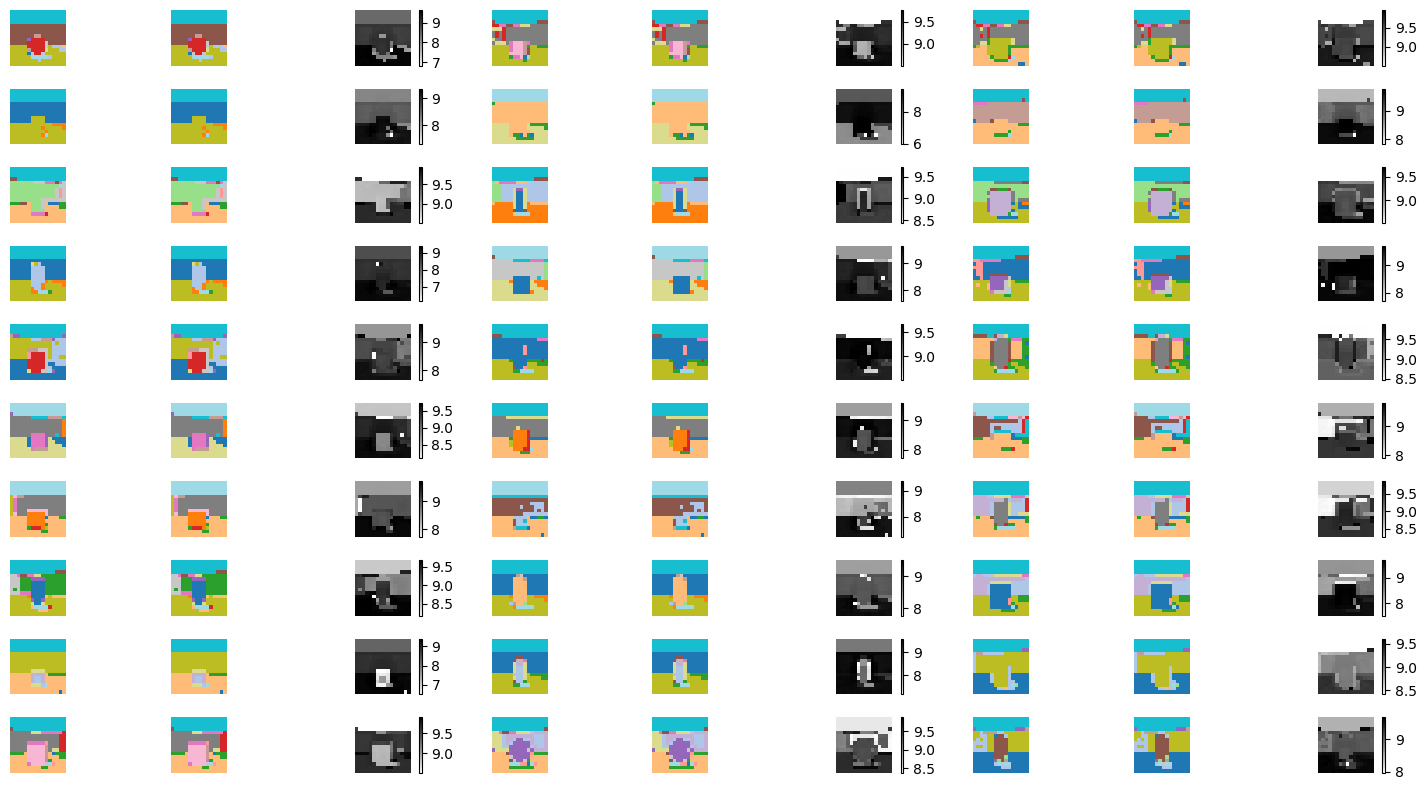

In [ ]:
plot_all_decode(test_y,most_probable,confidence,10,3)

In [ ]:
n_rec = 100 #n_test_samples

# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model.predict({'inputs_embeds': train_x[:n_rec].astype('float32'), 'labels': train_y[:n_rec].astype('float32')}, batch_size=256)

logits2 = reconstructions.logits
most_probable2 = logits2.argmax(axis=-1)

1/1 [==============================] - 1s 1s/step


In [ ]:
model.evaluate({'inputs_embeds': masked_test_x[:n_rec].astype('float32'), 'labels': test_y[:n_rec].astype('float32')}, batch_size=256)

1/1 [==============================] - 1s 605ms/step - loss: 1.0316


1.0316369533538818

In [ ]:
confidence2=logits2.max(axis=-1)

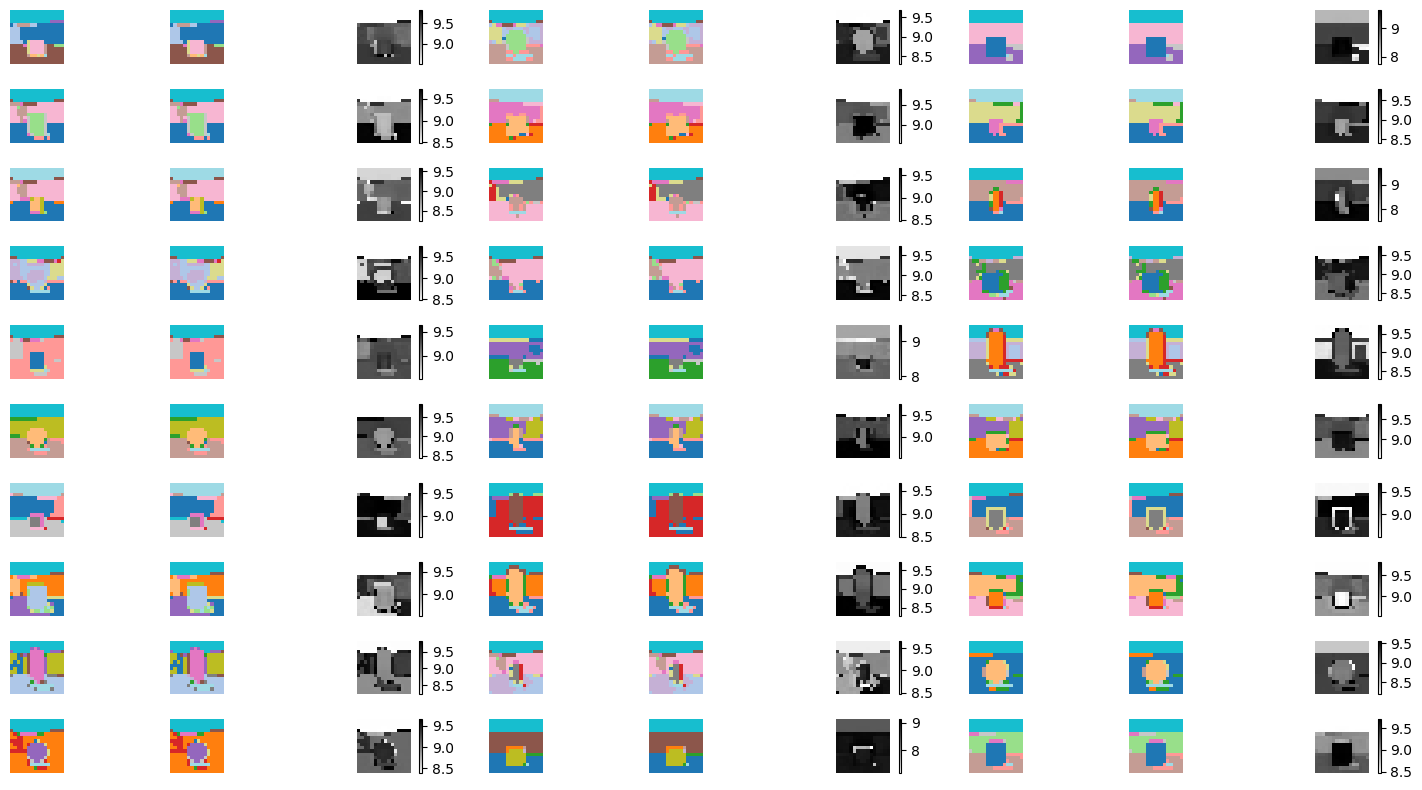

In [ ]:
plot_all_decode(train_y,most_probable2,confidence2,10,3)

In [ ]:
confidence2.min()

6.974117

In [ ]:
def masking(train_x,mask_perc):
  n_samples=train_x.shape[0]
  n_tokens=np.prod(train_x.shape[1])
  mask_token=0
  mask = np.random.default_rng().choice([True, False], size=(n_samples, n_tokens), p=[mask_perc, 1 - mask_perc])
  masked_train_x = np.copy(train_x)
  masked_train_x[mask] = mask_token
  return masked_train_x




In [ ]:
random_data=masking(test_data,0)

NameError: name 'test_data' is not defined

In [ ]:
n_rec = 50
mask_levels=np.array([0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
mask_number=np.round(mask_levels*256).astype('int')

#n = mask_levels.size
n=12

selective_evals=np.zeros(n)
random_evals=np.zeros(n)
selective_evals2=np.zeros(n)
random_evals2=np.zeros(n)



test_data=test_x[:n_rec]
test_labels=test_y[:n_rec]
reconstructions = model.predict({'inputs_embeds': test_data.astype('float32'), 'labels': test_labels.astype('float32')}, batch_size=256)
logits = reconstructions.logits
most_probable = logits.argmax(axis=-1)
confidence=logits.max(axis=-1)

sorted_conf= np.sort(confidence,axis=-1)

for i in tqdm(range(n)):
  thresh=sorted_conf[:,mask_number[i]]
  mask=confidence<thresh[:,np.newaxis]
  conf_temp=np.copy(confidence)
  data=np.copy(test_data)
  data[mask]=0
  selective_evals[i]= model.evaluate({'inputs_embeds': data.astype('float32'), 'labels': test_labels.astype('float32')}, batch_size=256)
  reconstructions = model.predict({'inputs_embeds': data.astype('float32'), 'labels': test_labels.astype('float32')}, batch_size=256)
  logits = reconstructions.logits
  most_probable = logits.argmax(axis=-1)
  selective_evals2[i]= (most_probable != test_labels).mean()




  random_data=masking(test_data,mask_levels[i])
  random_evals[i]= model.evaluate({'inputs_embeds': random_data.astype('float32'), 'labels': test_labels.astype('float32')}, batch_size=256)
  reconstructions = model.predict({'inputs_embeds': random_data.astype('float32'), 'labels': test_labels.astype('float32')}, batch_size=256)
  logits = reconstructions.logits
  most_probable = logits.argmax(axis=-1)
  random_evals2[i]= (most_probable != test_labels).mean()


  #evals[i]=model0.evaluate({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)


1/1 [==============================] - 1s 637ms/step


  0%|          | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 1s 644ms/step


  8%|▊         | 1/12 [00:05<00:59,  5.42s/it]

1/1 [==============================] - 1s 627ms/step


 17%|█▋        | 2/12 [00:08<00:38,  3.89s/it]

1/1 [==============================] - 1s 642ms/step


 25%|██▌       | 3/12 [00:11<00:31,  3.45s/it]

1/1 [==============================] - 1s 625ms/step


 33%|███▎      | 4/12 [00:13<00:25,  3.20s/it]

1/1 [==============================] - 1s 628ms/step


 42%|████▏     | 5/12 [00:16<00:21,  3.05s/it]

1/1 [==============================] - 1s 627ms/step


 50%|█████     | 6/12 [00:19<00:17,  2.95s/it]

1/1 [==============================] - 1s 661ms/step


 58%|█████▊    | 7/12 [00:22<00:14,  2.92s/it]

1/1 [==============================] - 1s 645ms/step


 67%|██████▋   | 8/12 [00:25<00:11,  2.89s/it]

1/1 [==============================] - 1s 622ms/step


 75%|███████▌  | 9/12 [00:27<00:08,  2.85s/it]

1/1 [==============================] - 1s 621ms/step


 83%|████████▎ | 10/12 [00:30<00:05,  2.79s/it]

1/1 [==============================] - 1s 581ms/step


 92%|█████████▏| 11/12 [00:33<00:02,  2.74s/it]

1/1 [==============================] - 1s 665ms/step


100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


In [ ]:
def plot_error(selective_evals,random_evals, Title):
  mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
  plt.plot(mask_levels,selective_evals, label='selective',)
  plt.plot(mask_levels,random_evals, label='random')

  plt.xlabel('percent masked')
  plt.ylabel('error rate')
  plt.title(Title + ', Full mask, Selective Attention')
  plt.xticks(mask_levels,mask_levels)
  plt.ylim(0,1)
  plt.grid()
  plt.legend()
  plt.show()

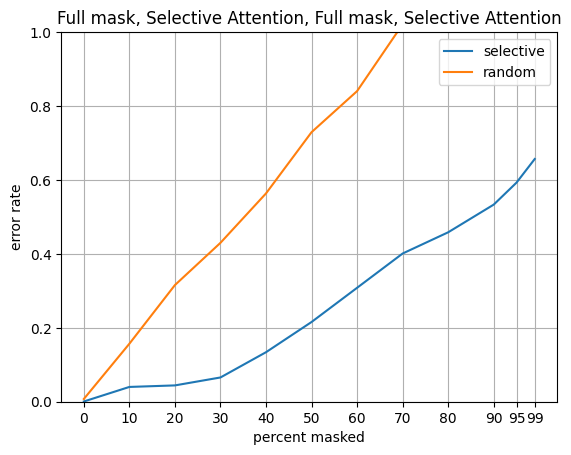

In [ ]:
plot_error(selective_evals,random_evals,'Full mask, Selective Attention')

In [ ]:
def plot_error(selective_evals,random_evals,selective_evals2,random_evals2, Title):
  mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
  plt.plot(mask_levels,selective_evals, label='selective',)
  plt.plot(mask_levels,random_evals, label='random')
  plt.plot(mask_levels,selective_evals2, label='selective2',)
  plt.plot(mask_levels,random_evals2, label='random2')

  plt.xlabel('percent masked')
  plt.ylabel('error rate')
  plt.title(Title + ', Full mask, Selective Attention')
  plt.xticks(mask_levels,mask_levels)
  plt.ylim(0,1)
  plt.grid()
  plt.legend()
  plt.show()

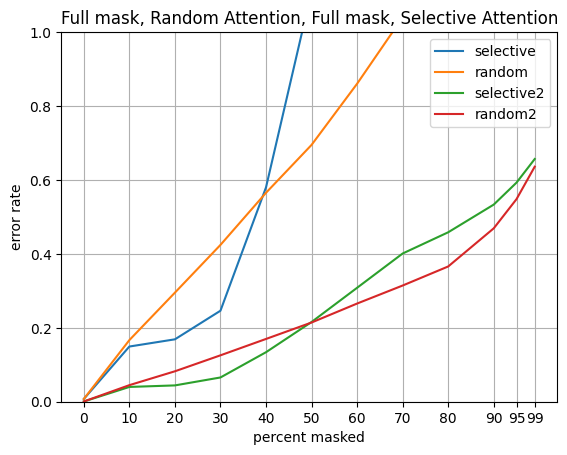

In [ ]:
plot_error(selective_evals,random_evals, selective_evals2,random_evals2,'Full mask, Random Attention')

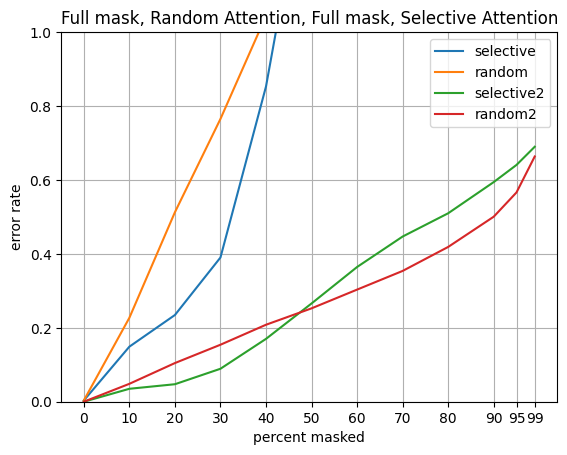

In [ ]:
plot_error(selective_evals,random_evals, selective_evals2,random_evals2,'Full mask, Random Attention')